## LANDIS PnET Output Sites Analysis
#### Dan Krofcheck

This workflow is designed to iterate over the output of the LANDIS PnET outputsites files and create aesthetic and informative illustrations of the results. The main challenges here are to deal with three core sets of outputs from the model, all of which are output in CSV format.

Cohort files
Establishment files
Site files

In [61]:
# ------- Notebook config
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

# ------- Load dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import gdal, os, osr
from scipy import stats
import random, ast, csv, math, glob

#### Setup direcory structure file names, and locations.

In [62]:
outputSite = 0

# Site file location
dataDir   = 'Y:/DanK/SFFireshed_Swap/SFF_CCSM_NoMan/replicate16/output/PNEToutputsites/'
siteNames = next(os.walk(dataDir))[1]
sitefile  = dataDir + siteNames[outputSite] + '/Site.csv'

# Establishment file location
estabfile = dataDir + siteNames[outputSite] + '/Establishment.csv'

# Cohort file location
cohortNames = []
for name in glob.glob(dataDir + siteNames[outputSite] + '/Cohort*'):
    cohortNames.append(name)
    
# Fire log location
fireDir = 'Y:/DanK/SFFireshed_Swap/SFF_CCSM_NoMan/replicate16/'
firelog = 'dynamic-fire-test-log.csv'
flog    = pd.read_csv(fireDir + firelog, index_col = False)

In [63]:
siteNames[outputSite]

'MCON3'

#### Read in a site file and fix the timestamp

In [64]:
siteDF     = pd.read_csv(sitefile)
year_start = int(np.floor(siteDF.Time.min()))
year_end   = int(np.ceil(siteDF.Time.max()))
tempTS     = pd.date_range(str(year_start), str(year_end), freq='MS')
TS         = tempTS[:-1]

siteDF['TS']    = TS
siteDF.index    = siteDF.TS
siteDF['Month'] = siteDF.index.month
siteDF['Year']  = siteDF.index.year

#### Create bins of column names to plot together

In [65]:
climate      = ['PAR0', 'Tday(C)', 'Precip(mm/mo)','VPD(kPa)']
precipFate   = ['Precip(mm/mo)', 'RunOff(mm/mo)', 
                     'Leakage(mm)','Transpiration(mm)','Interception(mm)']
soilMoisture   = ['water(mm)','PressureHead(mm)','SnowPack(mm)']
carbonExchange = ['GrossPsn(gC_m2_mo)',
                  'NetPsn(gC_m2_mo)', 'MaintenanceRespiration(gC_mo)']
biomass        = ['Root(gDW)', 'Fol(gDW)']
siteDF['Biomass(g)'] = siteDF[biomass].sum(axis=1)
biomass        = ['Biomass(g)', 'Root(gDW)', 'Fol(gDW)']



#### Carbon exchange plots

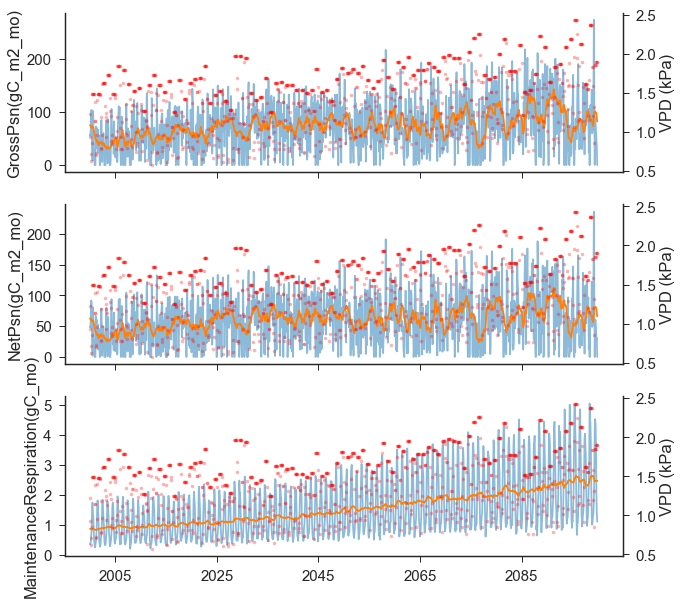

In [66]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (10,10), sharex = True)
axs = f.axes
idx = 0

datestart = '2000-01-01'
dateend   = '2099-12-01'
for sitevar in carbonExchange:
    ax = axs[idx]
    ax.plot(siteDF[sitevar].loc[datestart:dateend], alpha = 0.5)
    ax.plot(siteDF[sitevar].rolling(12).mean().loc[datestart:dateend])
    ax2 = ax.twinx()
    ax.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.plot(siteDF['VPD(kPa)'].rolling(6).max().loc[datestart:dateend], 
             ls = '', marker = '.', color = 'red', alpha = 0.3)
    ax2.set_ylabel('VPD (kPa)')

    
    ax.set_ylabel(sitevar)
    idx += 1
    
#sns.despine()
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.2)

#### Components of biomass plots

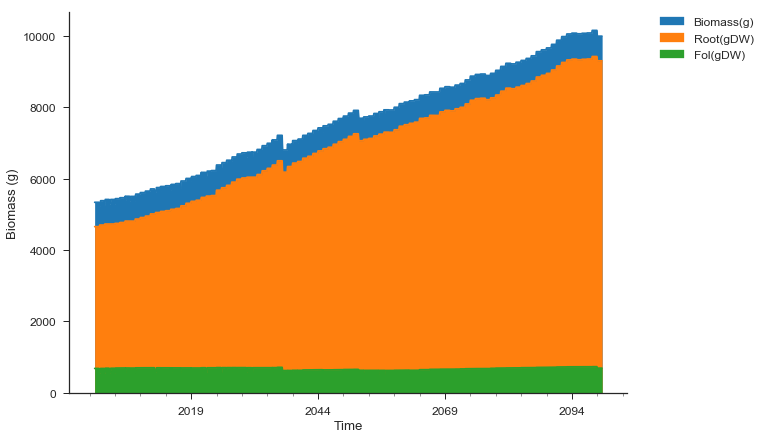

In [67]:
f, (ax) = plt.subplots(1,1, figsize = (10,7), sharex = True)
axs = f.axes
idx = 0

datestart = '2000-01-01'
dateend   = '2099-12-01'

for sitevar in biomass:
    siteDF[sitevar].loc[datestart:dateend].plot(ax = ax, kind = 'Area')
    ax.set_ylabel('AGB (Mg C ha$^{-1}$)')
    ax.set_xlabel('Time')
    maxY = ax.get_ylim()
    lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_ylabel(sitevar)
    
ax.set_ylim(maxY)
ax.set_ylabel('Biomass (g)')
sns.despine()
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.2)

#### Precipitation plots

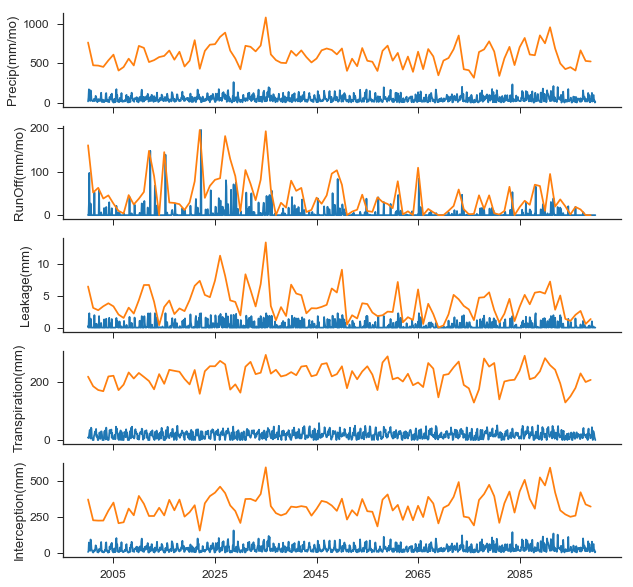

In [68]:

siteDF_A = siteDF.groupby(['Year']).sum().reset_index()
yearTS   = pd.date_range(str(siteDF_A.Year.min()), str(siteDF_A.Year.max()), freq='YS')
siteDF_A.index = yearTS

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize = (10,10), sharex = True)
axs = f.axes
idx = 0

datestart = '2000-01-01'
dateend   = '2099-12-01'
for sitevar in precipFate:
    ax = axs[idx]
    ax.plot(siteDF[sitevar].loc[datestart:dateend])
    ax.plot(siteDF_A[sitevar].loc['2000':'2099'])

    
    ax.set_ylabel(sitevar)
    idx += 1
    
sns.despine()
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.2)

#### Soil moisture plots

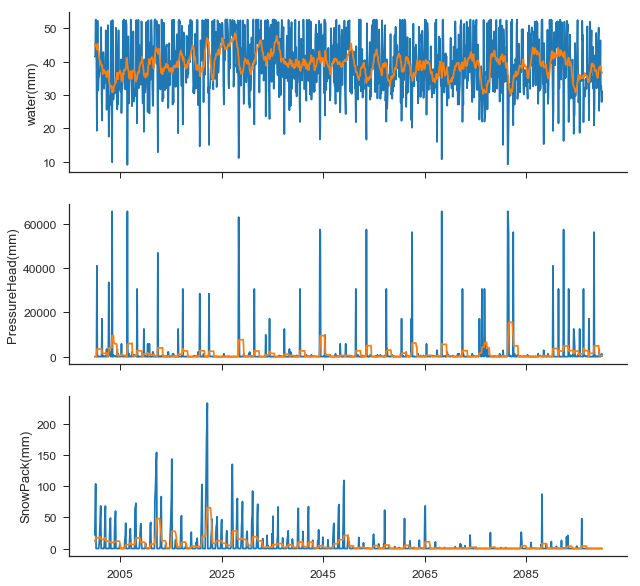

In [69]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (10,10), sharex = True)
axs = f.axes
idx = 0

datestart = '2000-01-01'
dateend   = '2099-12-01'
for sitevar in soilMoisture:
    ax = axs[idx]
    ax.plot(siteDF[sitevar].loc[datestart:dateend])
    ax.plot(siteDF[sitevar].rolling(12).mean().loc[datestart:dateend])
    
    ax.set_ylabel(sitevar)
    idx += 1
    
sns.despine()
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.2)

### Establishment
There are a ton of species in each of these outputsite files. However, only a subset of them play a role over the course of the 100 year sims. To cut down on the data generation, we can filter the appropriate species by only including those who have Est values == True at some point throughout the sim.

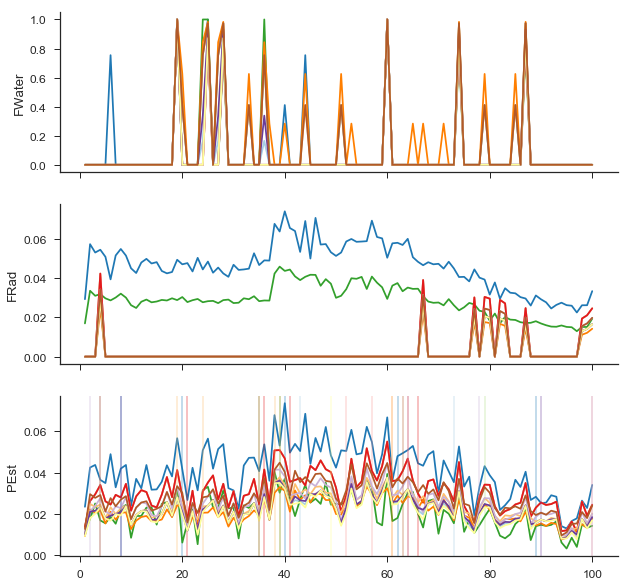

In [70]:
estDF = pd.read_csv(estabfile)

specCols = ['#a6cee3','#1f78b4','#b2df8a','#33a02c',
 '#fb9a99','#e31a1c','#fdbf6f','#ff7f00',
 '#cab2d6','#6a3d9a','#ffff99','#b15928']

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (10,10), sharex = True)
axs = f.axes

idx = 0
for species in estDF.Species.unique():
    specDF = estDF[estDF.Species == species]
    color = specCols[idx]
    ax1.plot(specDF.Year, specDF['FWater'], color = color)
    ax2.plot(specDF.Year, specDF['FRad'], color = color)
    ax3.plot(specDF.Year, specDF['Pest'], color = color)

    for year in specDF.Year:
        specYear = specDF[specDF.Year == year]
        if specYear.Est.values == True:
            ax3.axvline(year, color = color, 
                        linestyle = '-', alpha = 0.3)
    idx += 1
    
    ax1.set_ylabel('FWater')
    ax2.set_ylabel('FRad')
    ax3.set_ylabel('PEst')
    
sns.despine()
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.2)

#### Descriptive statistics by species

In [71]:
year_start = '2000-01-01'
year_end   = '2100-12-31'
tempTS     = pd.date_range(str(year_start), str(year_end), freq='Y')

for species in estDF.Species.unique():
    specDF = estDF[estDF.Species == species]
    specDF.index = tempTS[:-1]
    
    specDF.Est[specDF.Est == True].count()

In [72]:
### --- to do ---
### Time series plot of total establishment, 
### pie chart of percentage of total est by species every 10 years

In [73]:
idx = 0
for cohort in cohortNames:
    cohortDF = pd.read_csv(cohort)
    if cohortDF.empty == False:
        year_start = int(np.floor(cohortDF.Time.min()))
        year_end   = int(np.ceil(cohortDF.Time.max()))
        tempTS     = pd.date_range(str(year_start), str(year_end), freq='MS')
        TS         = tempTS[:-1]

        cohortDF['TS']    = TS
        cohortDF.index    = cohortDF.TS
        cohortDF['Month'] = cohortDF.index.month
        cohortDF['Year']  = cohortDF.index.year
        cohortDF['speciesName'] = cohort.split('\\')[1].split('_')[1]
        cohortDF['estabYear']   = cohort.split('\\')[1].split('_')[2].split('.')[0]
        cohortDF['uniqueC'] = cohort.split('\\')[1].split('_')[1] + cohort.split('\\')[1].split('_')[2].split('.')[0]

        if idx == 0:
            allCohorts = cohortDF
        else:
            allCohorts = pd.concat([allCohorts, cohortDF])
    idx += 1
        
    

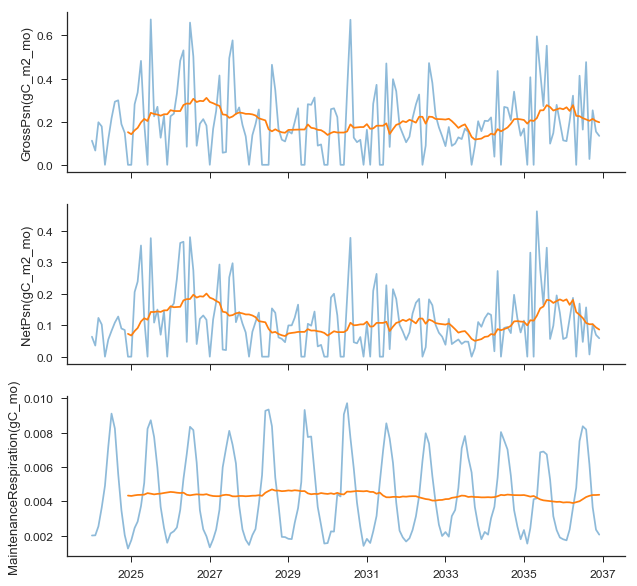

In [74]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (10,10), sharex = True)
axs = f.axes
idx = 0

for sitevar in carbonExchange:
    ax = axs[idx]
    ax.plot(cohortDF[sitevar].loc[datestart:dateend], alpha = 0.5)
    ax.plot(cohortDF[sitevar].rolling(12).mean().loc[datestart:dateend])

    
    ax.set_ylabel(sitevar)
    idx += 1
    
sns.despine()
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.2)

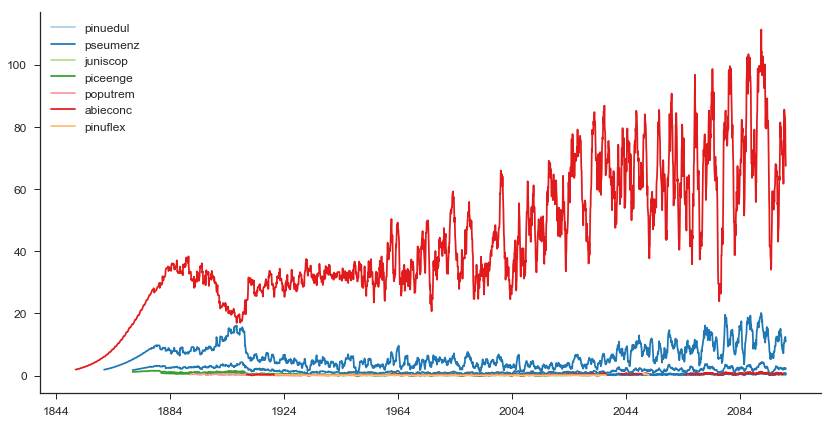

In [75]:
legendEntries = []
f, (ax1) = plt.subplots(1, 1, figsize = (14,7))
axs = f.axes
idx = 0
for species in allCohorts.speciesName.unique():
    specIdx = 0
    specDF = allCohorts[allCohorts.speciesName == species]
    for thisCohort in specDF.uniqueC.unique():
        thisCDF = specDF[specDF.uniqueC == thisCohort]
        ax1.plot(thisCDF['GrossPsn(gC_m2_mo)'].rolling(12).mean(), 
                 color = specCols[idx])
        if specIdx == 0:
            legendEntries.append(species)
        specIdx += 1

            
    idx += 1
    
# Fix up the legend to only show unique species
ax1.legend(labels = legendEntries)
ax = plt.gca()
leg = ax.get_legend()
handelIdx = 0
for handel in leg.legendHandles:
    handel.set_color(specCols[handelIdx])
    handelIdx += 1

sns.despine()
sns.set_context('notebook', font_scale=1.5)


(0, 200)

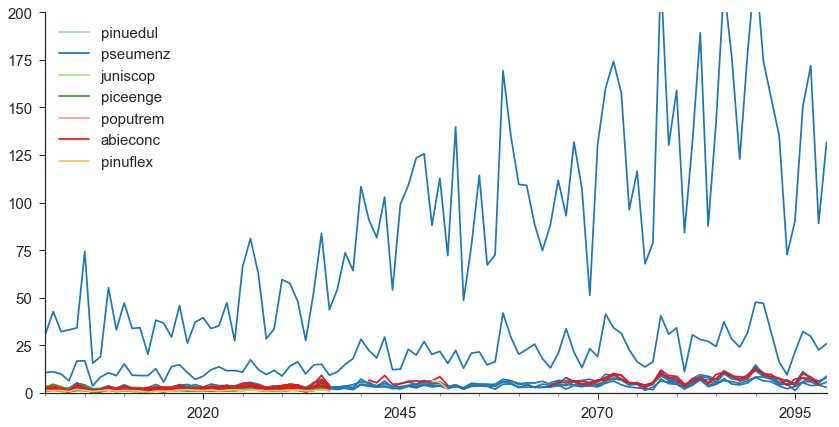

In [76]:
legendEntries = []
f, (ax1) = plt.subplots(1, 1, figsize = (14,7))
axs = f.axes
idx = 0
for species in allCohorts.speciesName.unique():
    specIdx = 0
    specDF  = allCohorts[allCohorts.speciesName == species]
    for thisCohort in specDF.uniqueC.unique():
        thisCDF   = specDF[specDF.uniqueC == thisCohort]
        annualSum = thisCDF.groupby(['Year']).sum().reset_index()
        
        year_start = int(np.floor(thisCDF.Year.min()))
        year_end   = int(np.ceil(thisCDF.Year.max()))
        TS         = pd.date_range(str(year_start), str(year_end), freq='YS')
        annualSum.index = TS

        annualSum['GrossPsn(gC_m2_mo)'].plot(color = specCols[idx])
        if specIdx == 0:
            legendEntries.append(species)
        specIdx += 1

            
    idx += 1
    
# Fix up the legend to only show unique species
ax1.legend(labels = legendEntries)
ax = plt.gca()
leg = ax.get_legend()
handelIdx = 0
for handel in leg.legendHandles:
    handel.set_color(specCols[handelIdx])
    handelIdx += 1

ax1.set_xlim([datestart, dateend])
sns.despine()
sns.set_context('notebook', font_scale=1.5)
ax1.set_ylim([0,200])